### Exploratory Analysis

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import statsmodels.api as sm
from statsmodels.formula.api import ols

In [41]:
food = pd.read_csv('food_coded.csv')

In [42]:
df2 = food[['GPA', 'Gender' , 'calories_chicken', 'turkey_calories', 'income', 'employment', 'father_education', 'mother_education', 'grade_level', 'eating_out', 'on_off_campus', 'weight', 'cook','cuisine', 'exercise', 'drink','breakfast', 'parents_cook', 'nutritional_check']]

In [43]:
# making variable of the % correct. we could not find the other actual calorie counts of others
df2['calories_chicken_prop'] = df2['calories_chicken']/720
df2['calories_turkey_prop'] = df2['turkey_calories']/690

In [44]:
# Cleaning GPA, making bins
df2['GPA'] = df2['GPA'].str[:3]
df2['GPA'].replace(['Per','Unk'], None, inplace=True)
df2['GPA'].value_counts()
df2['GPA'] = df2['GPA'].astype(float)

In [6]:
def plotting(plot, title, xlabel, ylabel,legend):
    plot.plot()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(legend)

In [7]:
def check_anova_assumptions(results, variable):
    #normality
    print("normality:",stats.shapiro(results.resid))
    
    # homogenity of var
    print("variance homogeneity:",stats.levene(df2['calories_chicken_prop'][df2[variable] == 1],
             df2['calories_chicken_prop'][df2[variable] == 2],
             df2['calories_chicken_prop'][df2[variable] == 3],
             df2['calories_chicken_prop'][df2[variable] == 4],
             df2['calories_chicken_prop'][df2[variable] == 5]))
    

## What type of students make better guesses for food calories? 
Guessing proportion of chicken & turkey vs:
- GPA
- family education
- income
- cook 
- living situation 
- eating out
- exercising


In [8]:
corr_columns = df2[['GPA','income','employment','father_education', 'mother_education', 'grade_level', 'eating_out','cook', 'exercise','calories_chicken_prop','calories_turkey_prop']]
corr_columns.corr()['calories_chicken_prop'].sort_values(ascending=False)

calories_chicken_prop    1.000000
calories_turkey_prop     0.397642
income                   0.144076
GPA                      0.140987
grade_level              0.113915
eating_out               0.024428
father_education         0.008014
cook                    -0.040738
employment              -0.057861
mother_education        -0.064962
exercise                -0.106730
Name: calories_chicken_prop, dtype: float64

In [9]:
df2['mother_education'].value_counts()

4.0    46
2.0    30
5.0    23
3.0    18
1.0     5
Name: mother_education, dtype: int64

In [10]:
corr_columns.corr()['calories_turkey_prop'].sort_values(ascending=False)

calories_turkey_prop     1.000000
calories_chicken_prop    0.397642
GPA                      0.237495
income                   0.133007
grade_level              0.127848
eating_out               0.090734
father_education         0.049771
employment               0.020998
cook                     0.020644
mother_education         0.007524
exercise                -0.025442
Name: calories_turkey_prop, dtype: float64

Based off these correlations, I will choose to investigate GPA, income, grade_level, eating_out, exercise, and mother_education. I will also investigate cooking habits because I would assume that this type of behavior would influence someones ability to guess calories.

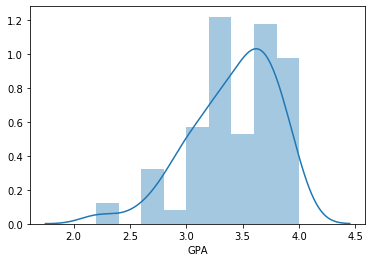

In [11]:
# GPA 
sns.distplot(df2['GPA'].dropna())

#### GPA vs. Calorie Guessing
Plotting GPA vs average proportion guesses. We chose mean because all the values have same ranges of proportions.

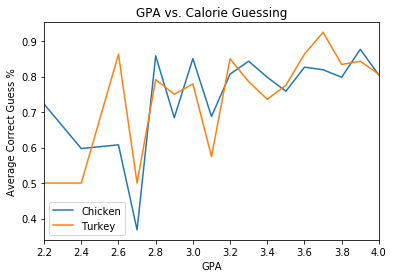

In [12]:
plotting(df2.groupby('GPA').mean()['calories_chicken_prop'], 'GPA vs. Calorie Guessing', 'GPA', 'Average Correct Guess %', ['Chicken','Turkey'])
plotting(df2.groupby('GPA').mean()['calories_turkey_prop'], 'GPA vs. Calorie Guessing', 'GPA', 'Average Correct Guess %', ['Chicken','Turkey'])

The plot seems to indicate that students with better academic performance (GPA), are better at guessing calories for the chicken and turkey meals. We'll investigate further with models.

In [13]:
results = ols('calories_chicken_prop ~ GPA', data=df2).fit()

check_anova_assumptions(results,'eating_out')

sm.stats.anova_lm(results)

normality: (0.8829671144485474, 2.138726884481912e-08)
variance homogeneity: LeveneResult(statistic=0.923962768854422, pvalue=0.4524733092297064)


,df,sum_sq,mean_sq,F,PR(>F)
GPA,1.0,0.080984,0.080984,2.453948,0.119841
Residual,121.0,3.993185,0.033002,NaN,NaN


In [14]:
results = ols('calories_turkey_prop ~ GPA', data=df2).fit()

check_anova_assumptions(results,'eating_out')

sm.stats.anova_lm(results)

normality: (0.9637536406517029, 0.002189408987760544)
variance homogeneity: LeveneResult(statistic=0.923962768854422, pvalue=0.4524733092297064)


,df,sum_sq,mean_sq,F,PR(>F)
GPA,1.0,0.33541,0.335410,7.232845,0.008169
Residual,121.0,5.61115,0.046373,NaN,NaN


Normality and variance homogeneity assumptions hold for both chicken and turkey proportions with GPA. Interestingly, proportion of correctness of chicken calorie content was an insignificant predictor, while the turkey calorie guess was found to be significant with a p-value of 0.008169. There is evidence to suggest that increasing academic performance is tied to stronger calorie guesses for the turkey meal.

#### Income vs. Calorie Guessing Proportions

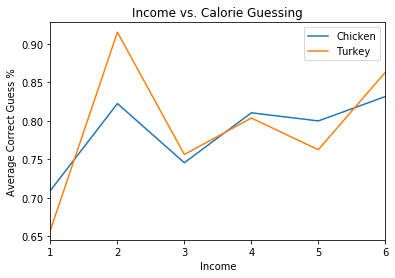

In [15]:
plotting(df2.groupby('income').mean()['calories_chicken_prop'], 'Income vs. Calorie Guessing', 'Income', 'Average Correct Guess %', ['Chicken','Turkey'])
plotting(df2.groupby('income').mean()['calories_turkey_prop'], 'Income vs. Calorie Guessing', 'Income', 'Average Correct Guess %', ['Chicken','Turkey'])

In [16]:
print('Checking equal var:',df2[df2['income'] == 1]['calories_chicken_prop'].var()/df2[df2['income'] == 6]['calories_chicken_prop'].var())

income1 = df2[df2['income'] == 1]['calories_chicken_prop']
income6 = df2[df2['income'] == 6]['calories_chicken_prop']

stats.ttest_ind(income1,income6, equal_var = False)

Checking equal var: 2.113990328340599


Ttest_indResult(statistic=-1.257217522415206, pvalue=0.2576270030160973)

In [17]:
results = ols('calories_chicken_prop ~ C(income)', data=df2).fit()
check_anova_assumptions(results,'eating_out')
sm.stats.anova_lm(results)

normality: (0.8977726697921753, 1.0335728006793943e-07)
variance homogeneity: LeveneResult(statistic=0.923962768854422, pvalue=0.4524733092297064)


,df,sum_sq,mean_sq,F,PR(>F)
C(income),5.0,0.145661,0.029132,0.865774,0.506393
Residual,118.0,3.970563,0.033649,NaN,NaN


In [18]:
results = ols('calories_turkey_prop ~ C(income)', data=df2).fit()
check_anova_assumptions(results,'eating_out')
sm.stats.anova_lm(results)

normality: (0.948286235332489, 0.00012428525951690972)
variance homogeneity: LeveneResult(statistic=0.923962768854422, pvalue=0.4524733092297064)


,df,sum_sq,mean_sq,F,PR(>F)
C(income),5.0,0.452624,0.090525,1.911669,0.097448
Residual,118.0,5.587748,0.047354,NaN,NaN


From the plot, it looks like generally, as income increases, people are better at guessing calories. However, after performing a t-test to check if there's a significant difference between the guessing abilities at income = 1 vs. income = 6, we found that there is no significant difference. The anova tables corraborate this finding, demonstrating that income is an insignificant predictor for the proportion of correct guesses. Therefore, we cannot conclude that higher income leads to a student's better guessing ability.

#### Family Education vs. Calorie Guessing Proportions
father_education, mother_education

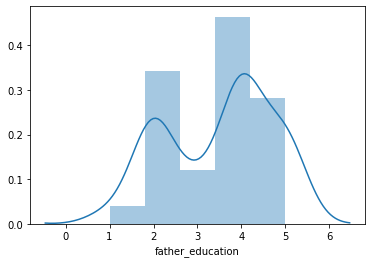

In [19]:
sns.distplot(df2['father_education'].dropna())

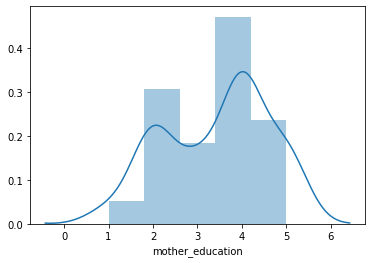

In [20]:
sns.distplot(df2['mother_education'].dropna())

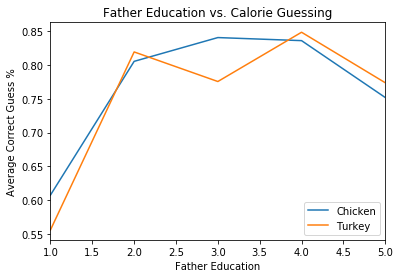

In [21]:
plotting(df2.groupby('father_education').mean()['calories_chicken_prop'], 'Father Education vs. Calorie Guessing', 'Father Education', 'Average Correct Guess %', ['Chicken','Turkey'])
plotting(df2.groupby('father_education').mean()['calories_turkey_prop'], 'Father Education vs. Calorie Guessing', 'Father Education', 'Average Correct Guess %', ['Chicken','Turkey'])

In [22]:
results = ols('calories_chicken_prop ~ C(father_education)', data=df2).fit()

check_anova_assumptions(results,'father_education')

sm.stats.anova_lm(results)

normality: (0.9068706631660461, 3.1141584599936323e-07)
variance homogeneity: LeveneResult(statistic=2.2425494393239345, pvalue=0.06848862695740304)


,df,sum_sq,mean_sq,F,PR(>F)
C(father_education),4.0,0.292123,0.073031,2.2726,0.065418
Residual,119.0,3.824101,0.032135,NaN,NaN


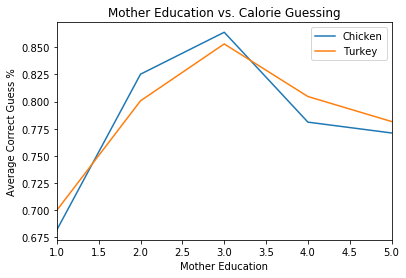

In [23]:
plotting(df2.groupby('mother_education').mean()['calories_chicken_prop'], 'Mother Education vs. Calorie Guessing', 'Mother Education', 'Average Correct Guess %', ['Chicken','Turkey'])
plotting(df2.groupby('mother_education').mean()['calories_turkey_prop'], 'Mother Education vs. Calorie Guessing', 'Mother Education', 'Average Correct Guess %', ['Chicken','Turkey'])

In [24]:
results = ols('calories_chicken_prop ~ C(mother_education)', data=df2).fit()

check_anova_assumptions(results,'mother_education')

sm.stats.anova_lm(results)

normality: (0.884896457195282, 2.9166976389660704e-08)
variance homogeneity: LeveneResult(statistic=0.3202693301750488, pvalue=0.8639240280617266)


,df,sum_sq,mean_sq,F,PR(>F)
C(mother_education),4.0,0.197286,0.049321,1.503227,0.205726
Residual,117.0,3.838816,0.032810,NaN,NaN


From these plots, it appears that parental education has an impact on the students ability to correctly guess calories in the chicken & turkey categories. However, after running an ANOVA test on both father and mother education, we conclude that there is actually no statistically significant difference between the mean calories_chicken_prop for different levels of education.

#### Cooking Habits vs. Calorie Guessing

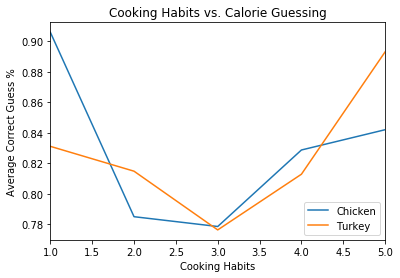

In [25]:
plotting(df2.groupby('cook').mean()['calories_chicken_prop'], 'Cooking Habits vs. Calorie Guessing', 'Cooking Habits', 'Average Correct Guess %', ['Chicken','Turkey'])
plotting(df2.groupby('cook').mean()['calories_turkey_prop'],  'Cooking Habits vs. Calorie Guessing', 'Cooking Habits', 'Average Correct Guess %', ['Chicken','Turkey'])

In [26]:
results = ols('calories_chicken_prop ~ C(cook)', data=df2).fit()

check_anova_assumptions(results,'cook')

sm.stats.anova_lm(results)

normality: (0.8851174712181091, 2.9878933105464967e-08)
variance homogeneity: LeveneResult(statistic=0.7189415219707149, pvalue=0.5806444965156123)


,df,sum_sq,mean_sq,F,PR(>F)
C(cook),4.0,0.201764,0.050441,1.618804,0.174107
Residual,117.0,3.645650,0.031159,NaN,NaN


From this plot and ANOVA, we can conclude that the frequency of cooking does not really help in their calorie guessings for chicken or turkey.

#### Living Situation vs. Calorie Guessing

Text(0, 0.5, 'Average Correct Guess %')

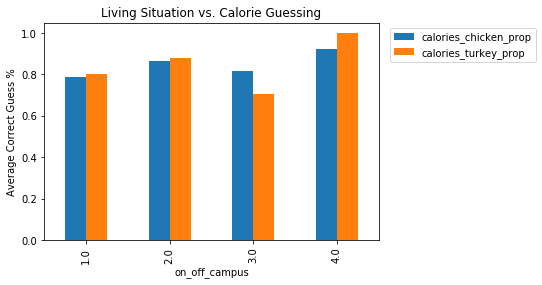

In [27]:
pd.merge(pd.DataFrame(df2.groupby('on_off_campus').mean()['calories_chicken_prop']),pd.DataFrame(df2.groupby('on_off_campus').mean()['calories_turkey_prop']), how='outer', on=['on_off_campus']).plot.bar()
plt.legend(loc='upper center', bbox_to_anchor=(1.25, 1))
plt.title('Living Situation vs. Calorie Guessing')
plt.ylabel('Average Correct Guess %')

In [28]:
results = ols('calories_chicken_prop ~ C(on_off_campus)', data=df2).fit()

#normality
print("normality:",stats.shapiro(results.resid))
    
# homogenity of var
print("variance homogeneity:",stats.levene(df2['calories_chicken_prop'][df2['on_off_campus'] == 1],
             df2['calories_chicken_prop'][df2['on_off_campus'] == 2],
             df2['calories_chicken_prop'][df2['on_off_campus'] == 3],
             df2['calories_chicken_prop'][df2['on_off_campus'] == 4]))

sm.stats.anova_lm(results)

normality: (0.8608649969100952, 1.9902040016006595e-09)
variance homogeneity: LeveneResult(statistic=0.7140163242379298, pvalue=0.545474525964267)


,df,sum_sq,mean_sq,F,PR(>F)
C(on_off_campus),3.0,0.109842,0.036614,1.10777,0.348799
Residual,120.0,3.966255,0.033052,NaN,NaN


From looking at the plot above, and from the ANOVA test, we conclude that living on or off campus does that affect how well a student makes caloric guesses.

#### Eating Out Frequency vs. Calorie Guessing

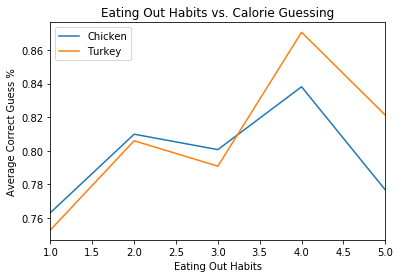

In [29]:
plotting(df2.groupby('eating_out').mean()['calories_chicken_prop'], 'Eating Out Habits vs. Calorie Guessing', 'Eating Out Habits', 'Average Correct Guess %', ['Chicken','Turkey'])
plotting(df2.groupby('eating_out').mean()['calories_turkey_prop'],  'Eating Out Habits vs. Calorie Guessing', 'Eating Out Habits', 'Average Correct Guess %', ['Chicken','Turkey'])

In [30]:
results = ols('calories_chicken_prop ~ C(eating_out)', data=df2).fit()

check_anova_assumptions(results,'eating_out')

sm.stats.anova_lm(results)

normality: (0.8731928467750549, 6.1867870826404214e-09)
variance homogeneity: LeveneResult(statistic=0.923962768854422, pvalue=0.4524733092297064)


,df,sum_sq,mean_sq,F,PR(>F)
C(eating_out),4.0,0.052747,0.013187,0.389223,0.816016
Residual,120.0,4.065554,0.033880,NaN,NaN


From the plot, and ANOVA we conclude that eating out habits also do not affect how well students can guess caloric content.

#### Exercise Frequency vs. Calorie Guessing

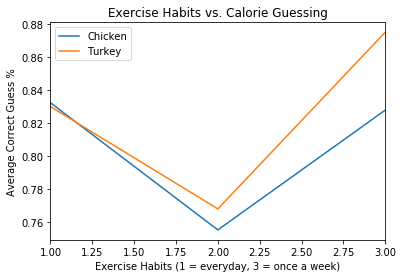

In [31]:
plotting(df2.groupby('exercise').mean()['calories_chicken_prop'], 'Exercise Habits vs. Calorie Guessing', 'Exercise Habits (1 = everyday, 3 = once a week)', 'Average Correct Guess %', ['Chicken','Turkey'])
plotting(df2.groupby('exercise').mean()['calories_turkey_prop'],  'Exercise Habits vs. Calorie Guessing', 'Exercise Habits (1 = everyday, 3 = once a week)', 'Average Correct Guess %', ['Chicken','Turkey'])

In [32]:
results = ols('calories_chicken_prop ~ C(exercise)', data=df2).fit()

#normality
print("normality:",stats.shapiro(results.resid))
    
# homogenity of var
print("variance homogeneity:",stats.levene(df2['calories_chicken_prop'][df2['exercise'] == 1],
             df2['calories_chicken_prop'][df2['exercise'] == 2],
             df2['calories_chicken_prop'][df2['exercise'] == 3]))

sm.stats.anova_lm(results)

normality: (0.8816098570823669, 5.767517663457511e-08)
variance homogeneity: LeveneResult(statistic=1.043210087988179, pvalue=0.35581248703866136)


,df,sum_sq,mean_sq,F,PR(>F)
C(exercise),2.0,0.155879,0.077940,2.318132,0.103293
Residual,109.0,3.664767,0.033622,NaN,NaN


From this plot, we cannot conclude that students who exercise more are better at calorie guessing. The usual assumption would be that people who exercise more tend to track their calories more, and thus should be at an advantage when guessing calories for foods. However, this dataset does not include any samples where students report ZERO exercise during the week so we cannot make a thorough investigation. In this plot, all students exercise at least once a week.

#### Conclusion
From all these plots, at first impression, we might conclude that students who are most conscious of their caloric intake are, on average, those with  higher income, the highest GPAs, have parents with advanced education, cook everyday, live away from home, eat out during the week, and exercise once a week. However, after completing a series of t-tests and ANOVA tests, actually all of these studied variables do not have statistically significant differences between their levels. It's important to note that even though the ANOVA tests failed the normality assumption ANOVA is fairly robust against this assumption, so still use the results from the tests.

Thus, we cannot conclude that income, GPA, parental education, cooking habits, living situation, eating out habits, and exercise habits have significant effects on how well students guess caloric content.

## What types of students will choose unhealthy food options over healthy ones?
Case studied: 
- Drink: Orange juice vs. Coke


Text(0.5, 0, 'Drink (1=OJ, 2=Coke)')

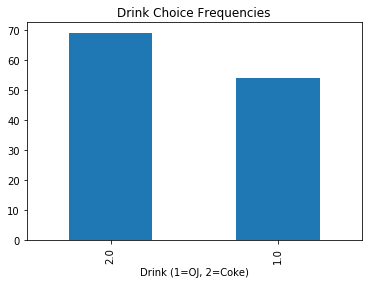

In [51]:
# check for imbalances in coke vs oj
df2['drink'].value_counts().plot(kind='bar')
plt.title('Drink Choice Frequencies')
plt.xlabel('Drink (1=OJ, 2=Coke)')

In [52]:
# biserial correlation between drink choice and numeric variables
# extract numeric variables from df, then get corr.
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df2.select_dtypes(include=numerics)

corr_columns = df2[['GPA','income','employment','father_education', 'mother_education', 'grade_level', 'eating_out','cook', 'exercise','calories_chicken_prop','calories_turkey_prop','drink']]


In [53]:
drink_correlations = pd.DataFrame([], columns=['Variable','Corr'])

for name in corr_columns.columns.drop('drink'):
    corr_df = corr_columns[[name, 'drink']].dropna()
    corr = stats.pointbiserialr(corr_df[name], corr_df['drink'])[0]
    df2 = pd.DataFrame([[name,corr]],columns=['Variable','Corr'])
    drink_correlations = drink_correlations.append(df2)

In [54]:
drink_correlations.sort_values('Corr', ascending=False)

,Variable,Corr
0,income,0.270804
0,mother_education,0.209404
0,cook,0.121020
0,exercise,0.105012
0,employment,0.082715
0,calories_turkey_prop,0.072235
0,father_education,0.022818
0,eating_out,0.018787
0,grade_level,-0.024461
0,calories_chicken_prop,-0.032772


From the biserial correlation, which measures the correlation between a binary and dichotomous variable, we conclude that income, mother's education, cooking habits, and exercise habits are the top most correlated variables to drink choices (oj vs. coke). To further investigate, we will make a few plots.

In [55]:
def drink_groupby_plot(variable, title, xlabel):
    d = df2.groupby([variable,'drink']).count().unstack()['GPA']
    d.columns=['orange_juice','coke']
    d.plot.bar()
    plt.title(title)
    plt.xlabel(xlabel)

In [56]:
#Initialize cleaned dataframe again.
df2 = food[['GPA', 'Gender' , 'calories_chicken', 'turkey_calories', 'income', 'employment', 'father_education', 'mother_education', 'grade_level', 'eating_out', 'on_off_campus', 'weight', 'cook','cuisine', 'exercise', 'drink','breakfast', 'parents_cook', 'nutritional_check']]
df2['calories_chicken_prop'] = df2['calories_chicken']/720
df2['calories_turkey_prop'] = df2['turkey_calories']/690
df2['GPA'] = df2['GPA'].str[:3]
df2['GPA'].replace(['Per','Unk'], None, inplace=True)
df2['GPA'].value_counts()
df2['GPA'] = df2['GPA'].astype(float)

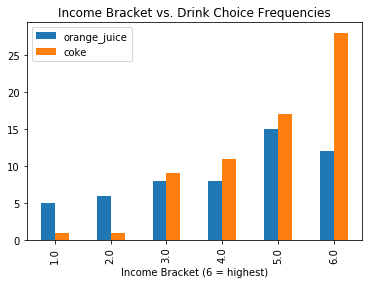

In [58]:
#Plot counts for each drink choice by income.
drink_groupby_plot('income', 'Income Bracket vs. Drink Choice Frequencies', 'Income Bracket (6 = highest)')

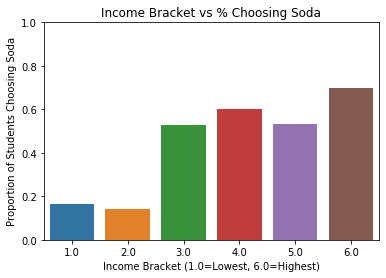

In [70]:
#Extract proportions for choice soda from the respective income brackets and plot. 
Proportions = [h.get_height() for h in sns.barplot(x='income', y='drink', data=df2, estimator=lambda x: sum(x==2)/len(x),ci = None).patches]
plt.title("Income Bracket vs % Choosing Soda")
plt.xlabel("Income Bracket (1.0=Lowest, 6.0=Highest)")
plt.ylabel("Proportion of Students Choosing Soda")
plt.ylim(0.0,1.0)
plt.show()

In [66]:
Incomes = [1,2,3,4,5,6]
d = {'Incomes': Incomes, 'Proportions': Proportions}
df3 = pd.DataFrame(data=d)
results = ols('Proportions ~ Incomes',data = df3).fit()
sm.stats.anova_lm(results)

,df,sum_sq,mean_sq,F,PR(>F)
Incomes,1.0,0.217557,0.217557,15.875088,0.016342
Residual,4.0,0.054817,0.013704,NaN,NaN


In [94]:
d = df2.groupby(['income','drink']).count().unstack()['GPA']
print(stats.chisquare(d[1],d[2]))

Power_divergenceResult(statistic=51.30744418979714, pvalue=7.480956643104142e-10)


In this specific dataset, more students with higher income associate a 'drink' with soda (coke) over orange juice. Students with lower income associate drinks with orange juice over soda. Running a chi-square test indicates that the choice of drink is different depending on the income bracket of the student.

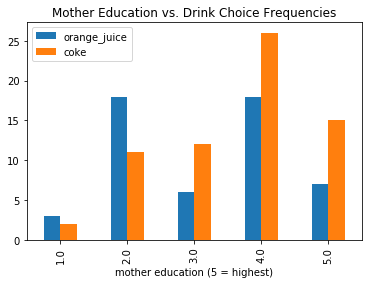

In [49]:
#Plot counts for each drink choice by education of mother.
drink_groupby_plot('mother_education', 'Mother Education vs. Drink Choice Frequencies', 'mother education (5 = highest)')

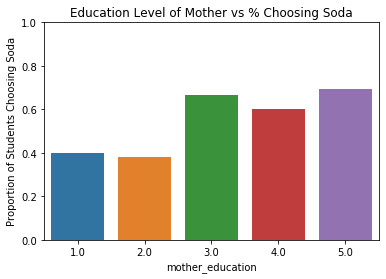

In [95]:
#Extract proportions for choice soda for each level of education and plot.
Proportions = [h.get_height() for h in sns.barplot(x='mother_education', y='drink', data=df2, estimator=lambda x: sum(x==2)/len(x),ci = None).patches]
plt.title("Education Level of Mother vs % Choosing Soda")
plt.ylabel("Proportion of Students Choosing Soda")
plt.ylim(0.0,1.0)
plt.show()

In [96]:
Education = [1,2,3,4,5]
d = {'Mothers_Education': Education, 'Proportions': Proportions}
df3 = pd.DataFrame(data=d)
results = ols('Proportions ~ Mothers_Education',data = df3).fit()
sm.stats.anova_lm(results)

,df,sum_sq,mean_sq,F,PR(>F)
Mothers_Education,1.0,0.065933,0.065933,8.595085,0.060915
Residual,3.0,0.023013,0.007671,NaN,NaN


In [97]:
d = df2.groupby(['mother_education','drink']).count().unstack()['GPA']
print(stats.chisquare(d[1],d[2]))

Power_divergenceResult(statistic=14.682750582750582, pvalue=0.005406533304259547)


Similarly, in this dataset, more students whose mothers have higher education associate a 'drink' with soda (coke) over orange juice. More students whose mothers have lower education appear to associate drinks with orange juice. A chi-square test indicates that this association is significant across differing levels of 'mothers_education'.

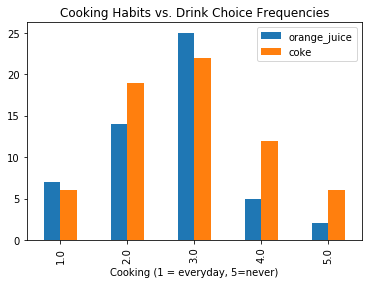

In [67]:
#Plot counts for each drink choice by cooking habits.
drink_groupby_plot('cook', 'Cooking Habits vs. Drink Choice Frequencies', 'Cooking (1 = everyday, 5=never)')

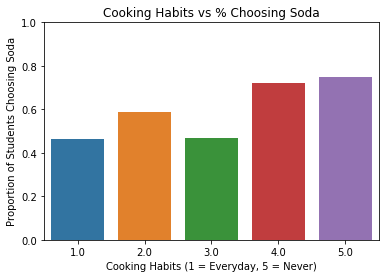

In [71]:
#Extract proportions for choice soda and plot against cooking habits.
Proportions = [h.get_height() for h in sns.barplot(x='cook', y='drink', data=df2, estimator=lambda x: sum(x==2)/len(x),ci = None).patches]
plt.title("Cooking Habits vs % Choosing Soda") 
plt.xlabel("Cooking Habits (1 = Everyday, 5 = Never)")
plt.ylabel("Proportion of Students Choosing Soda")
plt.ylim(0.0,1.0)
plt.show()

In [98]:
Cook = [1,2,3,4,5]
d = {'Cooking_Habits': Cook, 'Proportions': Proportions}
df3 = pd.DataFrame(data=d)
results = ols('Proportions ~ Cooking_Habits',data = df3).fit()
sm.stats.anova_lm(results)

,df,sum_sq,mean_sq,F,PR(>F)
Cooking_Habits,1.0,0.065933,0.065933,8.595085,0.060915
Residual,3.0,0.023013,0.007671,NaN,NaN


In [99]:
d = df2.groupby(['cook','drink']).count().unstack()['GPA']
print(stats.chisquare(d[1],d[2]))

Power_divergenceResult(statistic=8.641547049441787, pvalue=0.07071095040626074)


In general, it appears that students who cook more often are less likely to associate 'drink' with soda. The corresponding chi-square test indicates that cooking habits are not quite significant for determining the choice of drink.

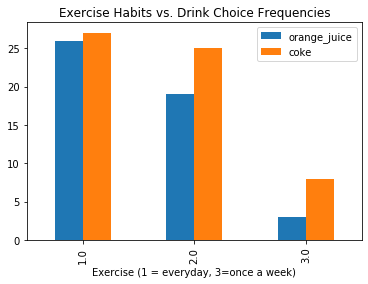

In [101]:
#Plot counts for each drink choice with level of exercise per week.
drink_groupby_plot('exercise', 'Exercise Habits vs. Drink Choice Frequencies', 'Exercise (1 = everyday, 3=once a week)')

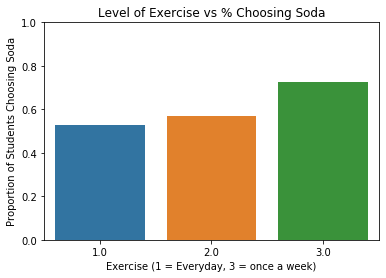

In [102]:
#Extract proportions for choice soda by level of exercise.
Proportions = [h.get_height() for h in sns.barplot(x='exercise', y='drink', data=df2, estimator=lambda x: sum(x==2)/len(x),ci = None).patches]
plt.title("Level of Exercise vs % Choosing Soda") 
plt.xlabel("Exercise (1 = Everyday, 3 = once a week)")
plt.ylabel("Proportion of Students Choosing Soda")
plt.ylim(0.0,1.0)
plt.show()

In [103]:
Exercise = [1,2,3]
d = {'Level_of_Exercise': Exercise, 'Proportions': Proportions}
df3 = pd.DataFrame(data=d)
results = ols('Proportions ~ Level_of_Exercise',data = df3).fit()
sm.stats.anova_lm(results)

,df,sum_sq,mean_sq,F,PR(>F)
Level_of_Exercise,1.0,0.020000,0.020000,8.591716,0.209307
Residual,1.0,0.002328,0.002328,NaN,NaN


In [104]:
d = df2.groupby(['exercise','drink']).count().unstack()['GPA']
print(stats.chisquare(d[1],d[2]))

Power_divergenceResult(statistic=4.602037037037037, pvalue=0.10015678021943415)


From this plot, we might assume that people who do exercise tend to associate drinks with soda over orange juice. The chi-square test comparing both drink choices does not demonstrate strong significance for differing levels of exercise. Additionally, since this dataset does not include any samples from people who do not exercise, we cannot make any conclusions about the drink associations with people who do not exercise.

#### Gender vs. Drink Choice

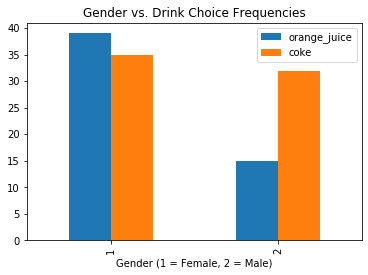

In [105]:
drink_groupby_plot('Gender', 'Gender vs. Drink Choice Frequencies', 'Gender (1 = Female, 2 = Male)')

In [107]:
d = df2.groupby(['Gender','drink']).count().unstack()['GPA']
print(stats.chisquare(d[1],d[2]))

Power_divergenceResult(statistic=9.488392857142857, pvalue=0.0020677587027907516)


Interestingly, women are more likely to associate drinks with orange juice whereas men associate drinks with coke. Under the assumption that juice is healthier than coke, I will investigate whether female students also check nutritional facts more than male students.

In [75]:
gender_nutr = df2.groupby(['nutritional_check','Gender']).count().unstack()['GPA']
gender_nutr.columns = ['Female','Male']
sums = gender_nutr.sum(axis=1)

In [76]:
gender_nutr['Female'] = gender_nutr['Female'] / sums
gender_nutr['Male'] = gender_nutr['Male'] / sums

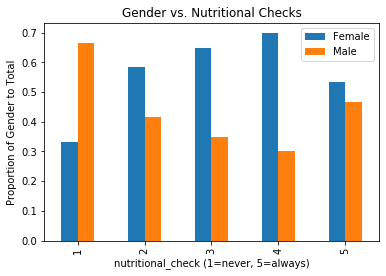

In [80]:
gender_nutr.plot.bar()
plt.title('Gender vs. Nutritional Checks')
plt.ylabel('Proportion of Gender to Total')
plt.xlabel('nutritional_check (1=never, 5=always)')
plt.show()

In [108]:
d = df2.groupby(['nutritional_check','Gender']).count().unstack()['GPA']
print(stats.chisquare(d[1],d[2]))

Power_divergenceResult(statistic=31.416483516483513, pvalue=2.517259767072417e-06)


From this plot, we can conclude that females are generally more 'health conscious,' meaning they check the nutrition facts on food much more frequently than men do. This could also be why females in this dataset associate drinks with juice over soda.

### Conclusion
After exploring the relationships between various characteristics of students with their respective choice of drink, we found a few significant associations. Income appears to be the most significant factor in this analysis. Other factors might have more broad and less apparant effects with regards to drink choice as demonstrated by the plots, by they are not significant enough to draw any major conclusions. We should also avoid conflating the drink choice results with any other health-conscious decisions the student might be making; it should be noted that both drink choices, juice and soda, pack considerable amounts of sugar and therefore may not be a reliable litmus test of health-consciousness.